# Standard Processing for UED Data Analysis

1. __Import all images__
    * Function called `gued.get_image_details` is used to load in all .tif files in the specified folder of interest. The function returns the images as a 3D data array, a 1D array of stage positions, file order, and total counts per image.

2. __Find Centers__
    * Find diffraction center for all images using the function called `gued.find_centers_pool` which runs the `find_center_alg` function in parallel

3. __Reject images with bad total counts__
    * Function called `gued.remove_counts` loads in the returns from `gued.get_image_details` and removes any images based on their total counts then returns the inputs with bad images removed.

4. __Subtract background__
    * The function called `gued.remove_background_pool` takes in a 3D array containing all image files and runs the hidden function `_remove_background` which creates a background image based on the corners of the original image. Then can either return the interpolated backgrounds or the cleaned data.
    * In cases where background images are taken as part of the experiment, use the `subtract_background` function with the data array and an average background image.

5. __Remove outlier instances of identical pixels__
    * This is generally referred to as removing x-ray hits or hot pixels. When working with large data sets, use the `gued.remove_xrays_pool` function. This function takes the 3D data array and runs the hidden function `_remove_xrays` in parallel. The function looks for instances of outlier pixels with respect to the average pixel value for all data. Returns the original data array with hot pixel values replaced with `np.nan`.

6. __Mask detector hole__
    * The function `gued.apply_mask` uses the `gued.mask_generator_alg` function to create a mask of `np.nan` values based on center and set radius. Returns masked data. Has the capability to apply multiple masks.

7. __Calculate diffraction center__
    * The function `gued.find_center_pool` runs the function `gued.find_center_alg` in parallel to find the center of all images. The pool function speeds up the process significantly but with small data sets can run `gued.find_center_alg` directly.

8. __Remove radial outliers__
    * The function `gued.remove_radial_outliers_pool` uses the hidden function `gued._preprocess_radial_data` which converts the data to polar coordinates, creates an interpolated average image from radial averages, then looks for instances of radial outliers and replaces them with `np.nan`.
    * This is by far the most time-consuming part of data processing. __Only do this with small data sets (i.e., after stage averaging) unless you're willing to spend a long time processing data.__ Takes 10 minutes per 100 images running in parallel.

9. __Apply median filter__
    * The function `gued.median_filter` applies a median filter to the data. Must replace `np.nan` values with radial average so this function is done in concert with the radial outlier removal (need to finalize).

10. __Retrieve Azimuthal Average__
    * The function `gued.azimuthal_average` takes the 3D data array and returns the azimuthal average for each data set.


## Global Variable Usage
The package gued relies on a few global variables which should be optimized for each experiment. The global variables are stored in gued_globals.py and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

## Import Packages

In [2]:
import numpy as np
import GUED as gued 
from gued_globals import *
import glob 
import time
import concurrent.futures

## Import all images

In [3]:
help(gued.get_image_details)

Help on function get_image_details in module GUED:

get_image_details(file_names, sort=True, plot=False, filter_data=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean): 
        default is set to False. When True, code prompts you for a minimum and maximum value then
        returns only the information from files within this range
    
    RETURNS:
    
    data_array (3d array): 
        Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
  

Path to images  C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\nitrophenyl code\20180823\Run\\*\*\*\ANDOR1_*.tif
Path to background images  \work\centurion\shared\UED_data\FY18_o-nitrophenol\20180823\Background\*\*\ANDOR1_*.tif
Number of files loaded:  1998
Number of background files loaded:  0
Load diffraction signal


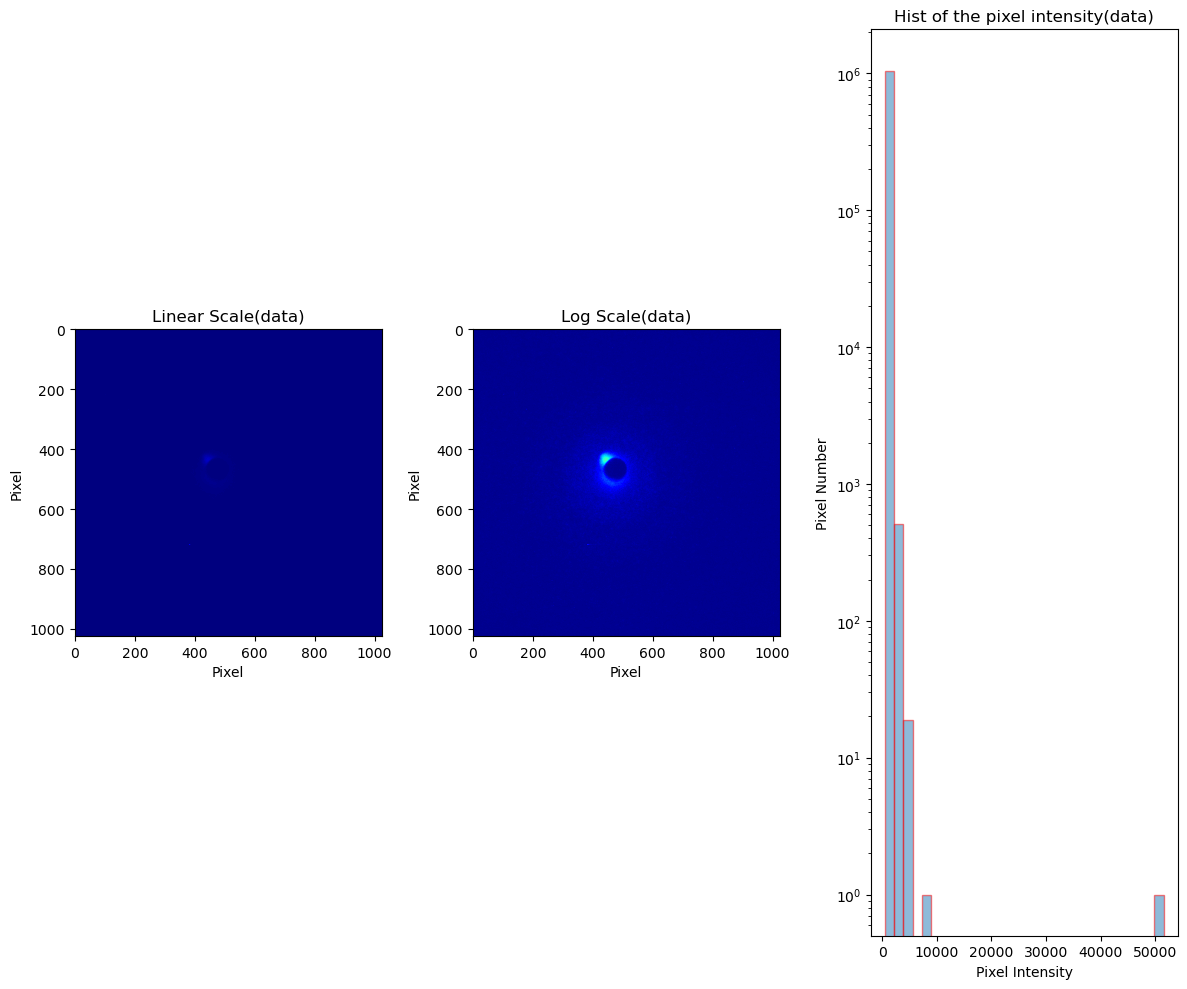

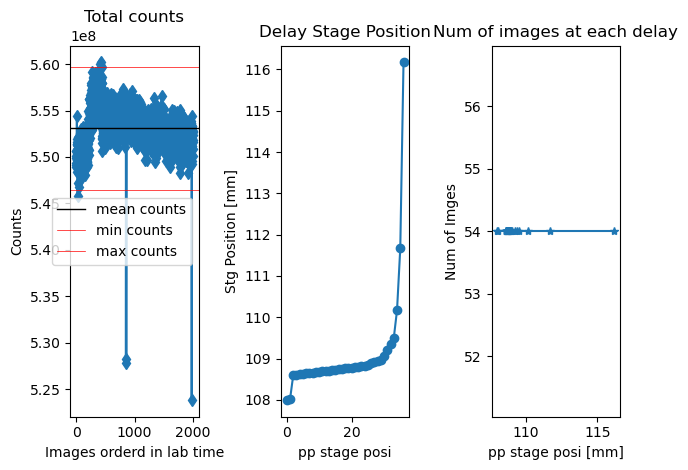

Image number read:  1998
Stage positions:  37
1998


In [5]:
dataPath = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823\\Run\\'
runPath = "\\*\\*\\*\\ANDOR1_*.tif"

bkg_path = '\\work\\centurion\\shared\\UED_data\\FY18_o-nitrophenol\\20180823\\Background\\*\\*\\ANDOR1_*.tif'

newPath = dataPath + runPath
print("Path to images ", newPath)
print("Path to background images ", bkg_path)

files = glob.glob(newPath)
bkg_files = glob.glob(bkg_path)
print("Number of files loaded: ", len(files))
print("Number of background files loaded: ", len(bkg_files))


print('Load diffraction signal');
data_array, stage_positions, file_order, counts = gued.get_image_details(files[:], sort=True, plot=True, filter_data=False)

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
print(len(np.unique(file_order)))

## Remove Images with Bad Counts

In [6]:
help(gued.remove_counts)

Help on function remove_counts in module GUED:

remove_counts(data_array, stage_positions, file_order, counts, std_factor=3, plot=False)
    Filters input parameters by removing any data where the total counts falls outside of the set filter. Default
    value is set to 3 standard deviations from the mean. Returns the same variables as it inputs but with
    different dimensions.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        Multidimensional array of N x 1024 x 1024 where N is the length of file_names list
    stage_pos (array): 
        One dimensional array of length N containing the stage positions associated with each image.
    file_order (array): 
        One dimensional array of length N that reflects the order with which the images are taken.
    counts(ndarray): 
        One dimensional array of length N containing the total counts after summing over each array
        element.
    
    OPTIONAL ARGUMENTS:
    
    std_factor (int): 
        Default value is 3. R

6  number of files removed from  1998  initial files


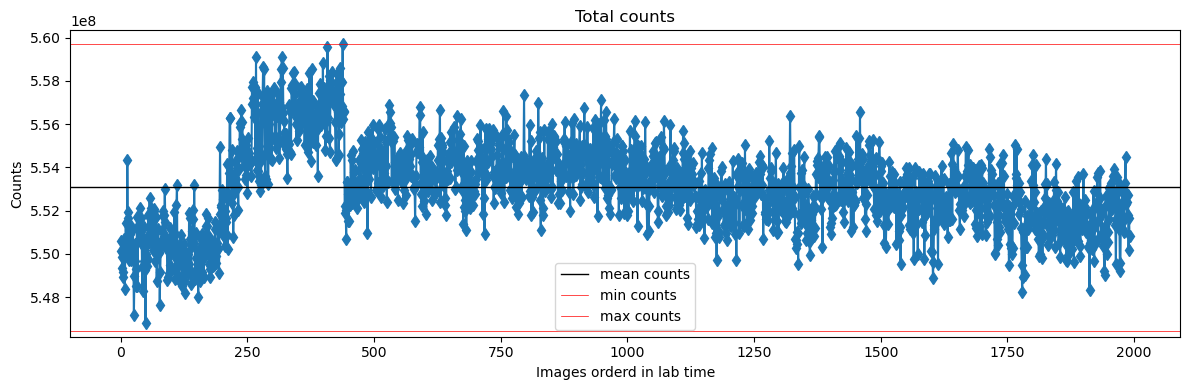

In [7]:
# Remove Outlier Images Based on Total Counts
data_array, stage_positions, file_order, counts = gued.remove_counts(data_array, stage_positions, file_order, counts, plot=True)


## Find Centers

First, adjust global variables to get centers accurately. Rerun with different values to check center reliability. Should not see center jumps more than one or two pixels. If this is happening you probably need to adjust global values

In [11]:
%%writefile gued_globals.py
### Global Variables for entire code
CENTER_GUESS = (460, 460)
RADIUS_GUESS = 40
DISK_RADIUS = 3
CORNER_RADIUS = 20
CHECK_NUMBER = 50


Overwriting gued_globals.py


In [12]:
help(gued.find_center_pool)

Help on function find_center_pool in module GUED:

find_center_pool(data_array, plot=True, print_stats=True)
    Finds center of each image in the data array using concurrent.futures.ThreadPoolExecutor to quickly process
    many data files.
    
    ARGUMENTS:
    
    data_array (ndarray): 
        array of image like data with shape Nx1024x1024
    
    OPTIONAL ARGUMENTS:
    
    plot (boolean): 
        Default is set to True. When true, plots an image of the values for center_x and center_y with respect to pixel number
    print_stats (boolean): 
        Default is set to True. Prints the average value for center_x and center_y and prints the percent failure rate.
    
    GLOBAL VARIABLES:
    
    CENTER_GUESS (tuple): 
        initial guess for center position
    RADIUS_GUESS (int): 
        initial guess for the radius
    DISK_RADIUS (int): 
        value for disk radius used in mapping
    
    RETURNS:
    
    center_x (array):
        One-dimensional array of x values 

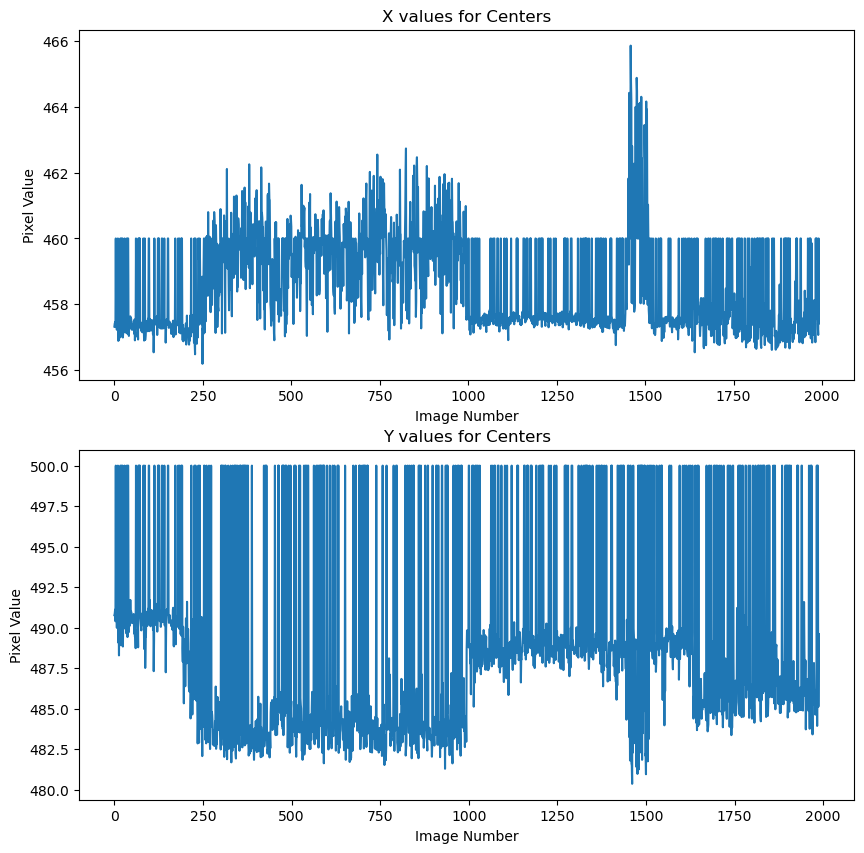

Averaged ctr is (458.33955316565266, 486.3499039264136)
Percentage of images where the center finding failed (i.e., found the guess value): 0.0


In [13]:
# only works when done before other steps...
center_x, center_y = gued.find_center_pool(data_array, plot=True)

## Subtract Background

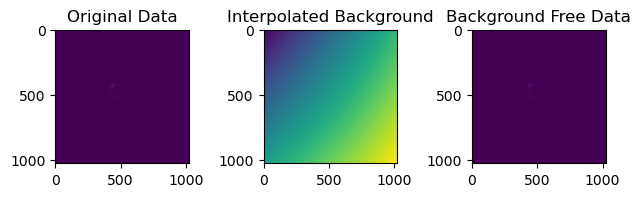

In [ ]:
# slightly faster than without pool, Threading = 45 seconds for 185 images, Processing = 20 seconds 185 images, None = 35 seconds 185 images
data_array = gued.remove_background_pool(data_array, remove_noise=True, plot=True)

## Remove Hot Pixels

Removing hot pixels from all data


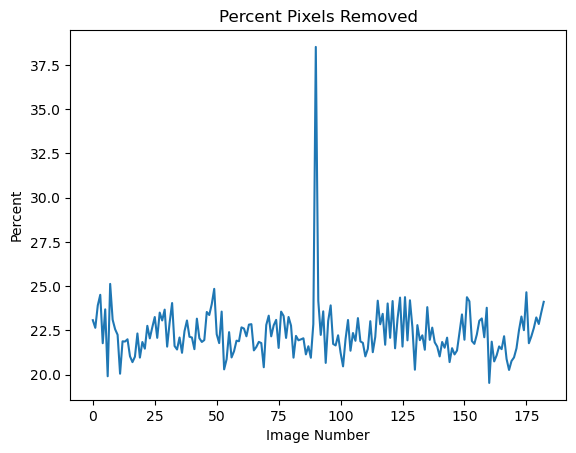

In [ ]:
data_array = gued.remove_xrays_pool(data_array, plot=True)

## Mask Beam Block and Artifacts


c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\Coding Lab Notebook\GUED_Analysis\GUED.py:789: RuntimeWarning: Mean of empty slice
  masked_mean = np.nanmean(masked_data, axis=0)


(183, 1024, 1024)


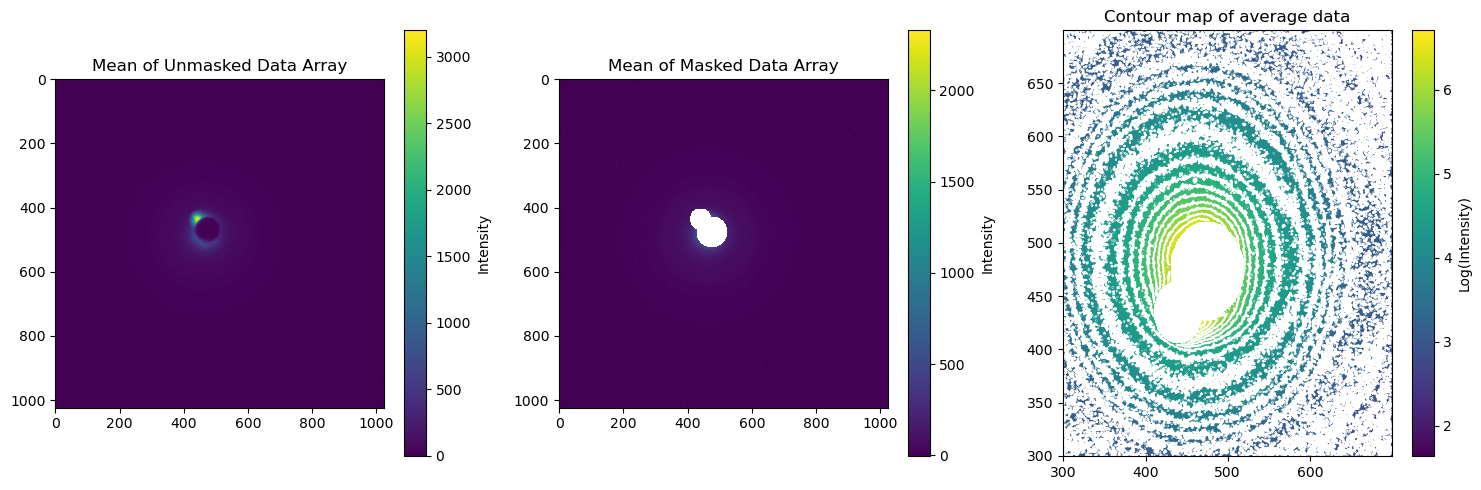

In [ ]:
# Find Mask
mean_data = np.nanmean(data_array, axis=0)
mask_center = [475,475]
mask_radius = 45
added_mask = [440, 435, 30]

# Apply Mask
data_array = gued.apply_mask(data_array, mask_center, mask_radius, add_mask=[added_mask], plot=True)



## Remove Radial Outliers

In [ ]:
ave_cx = np.nanmean(center_x)
ave_cy = np.nanmean(center_y)
center = [ave_cx, ave_cy]
center = [500, 500]

In [ ]:
data_array = gued.remove_radial_outliers_pool(data_array, center, plot=True)

Using average center
Removing radial outliers from all data
